# **XGBoost Model for Tooth Condition Prediction**

In this project, my aim is to evaluate an XGBoost model to predict whether a gearbox is in a "healthy" or "broken" state using various operational features. The data provided contains sensor readings collected from a gearbox during its operation, which I used to build a classification model. The task is to predict the condition of the gearbox based on these features.

### Features:
1. **a1, a2, a3, a4**: These are sensor readings capturing various operational parameters of the gearbox. They represent different aspects of the gearbox's behavior under operational conditions.
2. **load**: This feature represents the load applied to the gearbox, which is crucial for understanding the stress or operational conditions the gearbox is undergoing.
3. **condition**: This is the target variable of the model, indicating whether the gearbox is "healthy" (0) or "broken" (1). This is a binary classification problem, and the model's goal is to predict the condition based on the given features.

The goal of this project was to develop a model capable of accurately predicting whether the gearbox would be in a healthy or broken state based on the sensor data and load readings.

## Key Steps

1. **Data Loading and Preparation**:
   - I began by loading the dataset from a CSV file and then shuffled the data to randomize it before splitting it into features (`X`) and target (`y`).
   - The features include the sensor readings (`a1`, `a2`, `a3`, `a4`) and the load, while the target is the gearbox condition (`condition`).

2. **Train-Test-Validation Split**:
   - I split the data into three sets: training (80%), testing (15%), and validation (5%). The splitting process ensures that the model is trained on a diverse set of data and can generalize well.
   - To ensure the model performance is not biased, I used a standard scaler to normalize the feature values, which helps models like XGBoost perform better.

3. **XGBoost Model Setup**:
   - I configured an XGBoost classifier with specific hyperparameters that I manually tuned based on domain knowledge and experimentation.
   - The hyperparameters set include `n_estimators`, `max_depth`, `learning_rate`, `gamma`, and others. These control how the model learns and generalizes from the data.

4. **Cross-Validation**:
   - To validate the model’s performance, I implemented 10-fold cross-validation on the training data. This gave me a more robust estimate of the model's accuracy and stability by averaging results across multiple splits.
   - I then evaluated the mean accuracy and standard deviation across the folds to gauge how well the model performs on unseen data.

5. **Model Training**:
   - After cross-validation, I trained the XGBoost model on the full training set. I used early stopping during training, where the model stops if the validation error doesn’t improve after a specified number of rounds.
   - This technique helped avoid overfitting, ensuring that the model generalizes well to unseen data.

6. **Model Evaluation**:
   - Once trained, I evaluated the model on the test set using a variety of classification metrics, including:
     - Accuracy
     - Precision
     - Recall
     - F1 Score
     - Confusion Matrix
     - ROC Curve
     - Precision-Recall Curve
   - These metrics helped me understand the model's strengths and weaknesses, especially its ability to distinguish between healthy and broken conditions.

7. **Feature Importance**:
   - I used XGBoost's built-in feature importance functionality to understand which features contributed the most to the model's predictions.
   - The plot helped me interpret how each feature (e.g., `a1`, `a2`, `load`) affected the final decision.

8. **SHAP (Shapley Additive Explanations)**:
   - To further explain the model's predictions, I applied SHAP values, which allowed me to interpret the influence of each feature on the model's decision for individual predictions.
   - I generated SHAP summary and force plots, which provided valuable insights into how each feature impacted predictions for individual samples.

## Generated Files:
- `test_confusion_matrix.png`: A confusion matrix plot that shows the performance of the model on the test set.
- `roc_curve.png`: The ROC curve plot that visualizes the trade-off between the true positive rate and false positive rate.
- `pr_curve.png`: The Precision-Recall curve, which shows the balance between precision and recall.
- `feature_importance.png`: A plot that visualizes the importance of each feature in predicting the gearbox condition.
- `shap_summary.png`: A SHAP summary plot that shows the feature importance using Shapley values.
- `shap_force_plot.png`: A SHAP force plot for a single prediction, showing how the features influenced the model's decision.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, auc, precision_recall_curve, average_precision_score)
import xgboost as xgb
import shap
from sklearn.preprocessing import StandardScaler

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# 1. Load and Prepare Data
print("Loading and preparing data...")
df = pd.read_csv('processed_gearbox_data.csv')

Loading and preparing data...


In [4]:
print(df.describe())

                 a1            a2            a3            a4     condition  \
count  2.021119e+06  2.021119e+06  2.021119e+06  2.021119e+06  2.021119e+06   
mean   1.341575e-03  2.589083e-04  4.453338e-03  6.101136e-04  4.974032e-01   
std    6.157919e+00  4.408471e+00  3.963242e+00  4.466629e+00  4.999934e-01   
min   -5.872160e+01 -3.294430e+01 -2.916740e+01 -3.133450e+01  0.000000e+00   
25%   -3.265495e+00 -2.432110e+00 -2.116310e+00 -2.373490e+00  0.000000e+00   
50%   -7.987520e-02  9.292100e-02  4.860470e-02  1.161210e-01  0.000000e+00   
75%    3.135560e+00  2.582300e+00  2.196570e+00  2.483190e+00  1.000000e+00   
max    5.670660e+01  3.092830e+01  2.693890e+01  3.734990e+01  1.000000e+00   

               load  
count  2.021119e+06  
mean   4.564659e+01  
std    2.865902e+01  
min    0.000000e+00  
25%    2.000000e+01  
50%    5.000000e+01  
75%    7.000000e+01  
max    9.000000e+01  


### Summary Statistics

The dataset's summary statistics reveal the following key insights:

- The **mean** of `condition` is approximately `0.5`, suggesting that the dataset has a balanced distribution of healthy and faulty gearbox conditions.
- The **standard deviation** of `condition` is around `0.5`, which is expected for a binary variable and indicates variability in the occurrence of both healthy and faulty conditions.
- The **minimum** and **maximum** values for `condition` are `0` and `1`, respectively, confirming that this is a binary target variable.
- The vibration sensor measurements (`a1`, `a2`, `a3`, `a4`) have a broad range of values, with large standard deviations indicating variability in vibration intensities. This variability is expected as gearboxes can experience different operating conditions that affect vibration levels.

In [5]:
# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Separate features and target
X = df[['a1', 'a2', 'a3', 'a4', 'load']]
y = df['condition']

In [9]:
# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temp set into test (15%) and validation (5%) (0.25 of the 20% is 5% for validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [10]:
# Print the number of samples for each dataset
print(f"Number of samples in X_train: {X_train.shape[0]}")
print(f"Number of samples in X_test: {X_test.shape[0]}")
print(f"Number of samples in X_val: {X_val.shape[0]}")

print(f"Number of samples in y_train: {y_train.shape[0]}")
print(f"Number of samples in y_test: {y_test.shape[0]}")
print(f"Number of samples in y_val: {y_val.shape[0]}")

Number of samples in X_train: 1616895
Number of samples in X_test: 303168
Number of samples in X_val: 101056
Number of samples in y_train: 1616895
Number of samples in y_test: 303168
Number of samples in y_val: 101056


### Dataset Split Overview

The dataset has been split into training, testing, and validation sets as follows:

- **Training Set (`X_train` and `y_train`)**: 1,616,895 samples
- **Test Set (`X_test` and `y_test`)**: 303,168 samples
- **Validation Set (`X_val` and `y_val`)**: 101,056 samples

The training set is the largest, used to train the model. The test set is for final evaluation, while the validation set helps in tuning the model's hyperparameters and preventing overfitting. Both features (`X_*`) and target labels (`y_*`) have been split consistently across the sets.

In [11]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [12]:
# Print the number of samples for each scaled dataset
print(f"Number of samples in X_train_scaled: {X_train_scaled.shape[0]}")
print(f"Number of samples in X_test_scaled: {X_test_scaled.shape[0]}")
print(f"Number of samples in X_val_scaled: {X_val_scaled.shape[0]}")

Number of samples in X_train_scaled: 1616895
Number of samples in X_test_scaled: 303168
Number of samples in X_val_scaled: 101056


In [14]:
# 3. XGBoost Model with Manual Hyperparameters
print("\nTraining XGBoost model with manual hyperparameters...")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1
)


Training XGBoost model with manual hyperparameters...


In [16]:
print(f"Number of samples in X_train: {X_train_scaled.shape[0]}")
print(f"Number of samples in y_train: {y_train.shape[0]}")

Number of samples in X_train: 1616895
Number of samples in y_train: 1616895


In [17]:
from sklearn.model_selection import KFold, cross_val_score

# Initialize 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = cross_val_score(
    estimator=xgb_model,
    X=X_train_scaled,
    y=y_train,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1
)

# Print results
print("\nCross Validation Results (10-fold):")
print(f"Mean Accuracy: {cv_results.mean():.4f}")
print(f"Standard Deviation: {cv_results.std():.4f}")



Cross Validation Results (10-fold):
Mean Accuracy: 0.6186
Standard Deviation: 0.0009


In [18]:
pip install --upgrade xgboost

In [23]:
# Train final model on full training set with early stopping

eval_set = [(X_val_scaled, y_val)]

xgb_model.fit(
    X_train_scaled,
    y_train,
  # eval_set=eval_set,
  # eval_metric="logloss",
  # early_stopping_rounds=20,
    verbose=False
)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:27:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
# 4. Evaluate on Training Set
print("\nEvaluating on training set...")
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_proba_train = xgb_model.predict_proba(X_train_scaled)[:, 1]

# Metrics for Training Set
print("\nTraining Set Metrics:")
print(classification_report(y_train, y_pred_train))
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
print(f"F1 Score: {f1_score(y_train, y_pred_train):.4f}")


Evaluating on training set...

Training Set Metrics:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56    812937
           1       0.59      0.76      0.67    803958

    accuracy                           0.62   1616895
   macro avg       0.63      0.62      0.61   1616895
weighted avg       0.63      0.62      0.61   1616895

Accuracy: 0.6204
Precision: 0.5917
Recall: 0.7633
F1 Score: 0.6666


### **Model Performance Metrics**

- **Precision**:
  - **Class 0**: 0.67 (67% of predicted class 0 are actually class 0)
  - **Class 1**: 0.59 (59% of predicted class 1 are actually class 1)

- **Recall**:
  - **Class 0**: 0.48 (48% of actual class 0 were correctly predicted)
  - **Class 1**: 0.76 (76% of actual class 1 were correctly predicted)

- **F1-Score**:
  - **Class 0**: 0.56 (balance of precision and recall for class 0)
  - **Class 1**: 0.67 (better balance for class 1)

- **Accuracy**: 0.6204 (62% of total predictions were correct)

- **Macro Average**:
  - Precision: 0.63
  - Recall: 0.62
  - F1-Score: 0.61

- **Weighted Average**:
  - Precision: 0.63
  - Recall: 0.62
  - F1-Score: 0.61

### **Summary**:
- The model performs better at detecting **Class 1** (higher recall), but it struggles with **Class 0** (lower recall).
- **F1-Score** for class 1 is higher, indicating better balance between precision and recall for class 1.
- Accuracy is moderate at 62%, with room for improvement in **Class 0** predictions.


In [25]:
# Confusion Matrix for Training Set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_train, y_pred_train),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Broken'],
            yticklabels=['Healthy', 'Broken'])
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('train_confusion_matrix.png')
plt.close()

In [26]:
# 5. Evaluate on Test Set
print("\nEvaluating on test set...")
y_pred_test = xgb_model.predict(X_test_scaled)
y_pred_proba_test = xgb_model.predict_proba(X_test_scaled)[:, 1]


Evaluating on test set...


In [27]:
# Metrics for Test Set
print("\nTest Set Metrics:")
print(classification_report(y_test, y_pred_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.4f}")


Test Set Metrics:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56    151928
           1       0.59      0.76      0.67    151240

    accuracy                           0.62    303168
   macro avg       0.63      0.62      0.61    303168
weighted avg       0.63      0.62      0.61    303168

Accuracy: 0.6182
Precision: 0.5912
Recall: 0.7606
F1 Score: 0.6653


### Test Set Performance Metrics

- **Precision**:
  - **Class 0**: 0.67 (67% of predicted class 0 are actually class 0)
  - **Class 1**: 0.59 (59% of predicted class 1 are actually class 1)

- **Recall**:
  - **Class 0**: 0.48 (48% of actual class 0 were correctly predicted)
  - **Class 1**: 0.76 (76% of actual class 1 were correctly predicted)

- **F1-Score**:
  - **Class 0**: 0.56 (balance of precision and recall for class 0)
  - **Class 1**: 0.67 (better balance for class 1)

- **Accuracy**: 0.6182 (61.82% of total predictions were correct)

- **Macro Average**:
  - Precision: 0.63
  - Recall: 0.62
  - F1-Score: 0.61

- **Weighted Average**:
  - Precision: 0.63
  - Recall: 0.62
  - F1-Score: 0.61

### Summary:
- The model performs better at detecting **Class 1** (higher recall), but struggles with **Class 0** (lower recall).
- **F1-Score** for class 1 is higher, showing a better balance between precision and recall for class 1.
- Accuracy is moderate at 61.82%, with room for improvement in **Class 0** predictions.

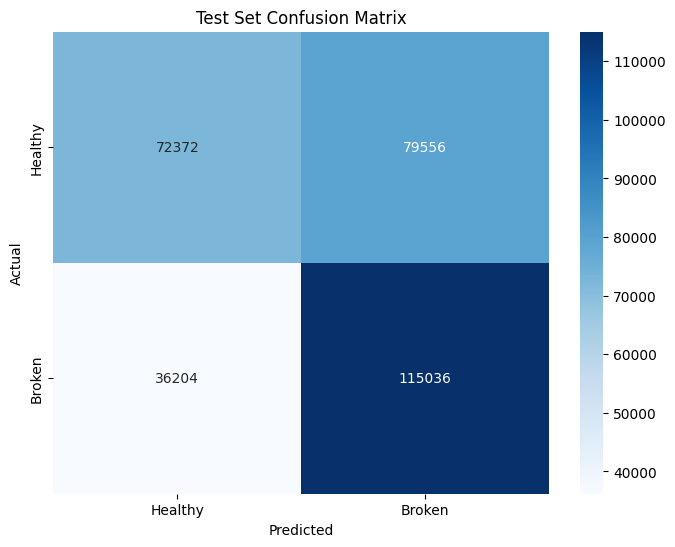

In [30]:
# Confusion Matrix for Test Set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Broken'],
            yticklabels=['Healthy', 'Broken'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('test_confusion_matrix.png')

plt.show()
plt.close()

### **ROC Curve Analysis**

The Receiver Operating Characteristic (ROC) curve plots the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) across all possible classification thresholds.

## Key Components

1. **Curve Elements**
   - **Main ROC Curve (orange)**: Shows TPR vs FPR at different thresholds
   - **Diagonal Line (blue dashed)**: Represents random guessing (AUC = 0.5)
   - **AUC Value**: Area Under Curve metric (shown in legend)

2. **Axes Interpretation**
   - X-axis (False Positive Rate): % of negatives incorrectly classified
   - Y-axis (True Positive Rate): % of positives correctly identified

3. **Threshold Dynamics**
   - Each point represents a different decision threshold
   - Upper left = conservative threshold (few FPs, may miss TPs)
   - Lower right = lenient threshold (catches more TPs but with more FPs)

## Why This Matters

1. **Model Performance Assessment**
   - AUC > 0.9 = Excellent discrimination
   - AUC 0.8-0.9 = Good discrimination
   - AUC 0.7-0.8 = Fair discrimination
   - AUC 0.6-0.7 = Poor discrimination
   - AUC ≤ 0.5 = No discrimination

2. **Threshold Selection**
   - Helps choose optimal cutoff based on business needs
   - Visualizes sensitivity/specificity tradeoffs

3. **Model Comparison**
   - Allows direct comparison of different models
   - Higher curves indicate better performance

## Advanced Interpretation

1. **Shape Analysis**
   - Steep initial rise = good early true positive capture
   - Late flattening = diminishing returns at higher FPRs

2. **AUC Interpretation**
   - Probability that model ranks random positive higher than negative
   - 0.8 AUC means 80% chance of correct ranking

3. **Business Context**
   - Medical diagnosis: Prefer high TPR (left upper)
   - Fraud detection: Prefer low FPR (lower left)



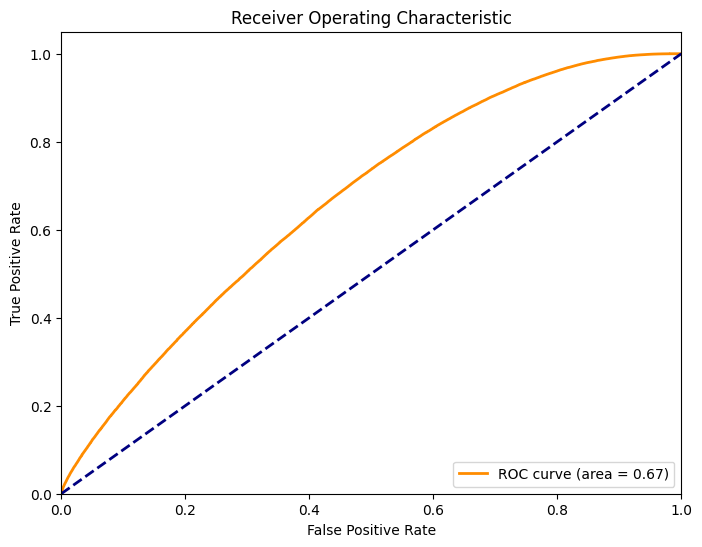

In [31]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

plt.show()
plt.close()

# Precision-Recall Curve Analysis

The Precision-Recall (PR) curve illustrates the trade-off between precision (positive predictive value) and recall (sensitivity) across different classification thresholds, particularly valuable for imbalanced datasets.

## Key Components

1. **Curve Components**:
   - **Main PR Curve (blue)**: Plots precision against recall at varying thresholds
   - **Area Under Curve (AUC)**: Average precision score (shown in legend)
   - **No-Skill Line**: Implicit baseline (horizontal at positive class prevalence)

2. **Axes Interpretation**:
   - X-axis (Recall): % of actual positives correctly identified (True Positive Rate)
   - Y-axis (Precision): % of predicted positives that are actual positives

3. **Threshold Dynamics**:
   - Lower right: Lenient threshold (high recall, lower precision)
   - Upper left: Strict threshold (high precision, lower recall)

## Why This Matters

1. **Imbalanced Data Performance**:
   - More informative than ROC for skewed class distributions
   - Focuses on correct prediction of the positive class

2. **Business Decision Support**:
   - Helps select thresholds based on precision/recall priorities
   - Critical for applications where false positives are costly

3. **Model Quality Assessment**:
   - AUC closer to 1.0 indicates better performance
   - Sharp drop-offs reveal performance cliffs


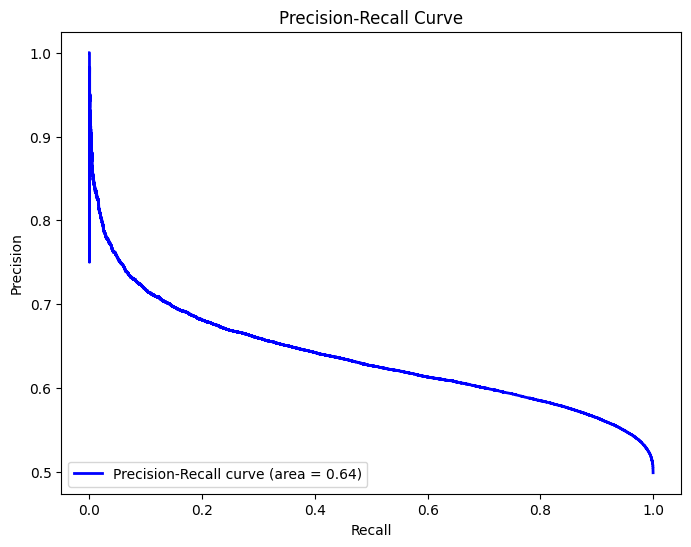

In [32]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = average_precision_score(y_test, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('pr_curve.png')

plt.show()
plt.close()

In [33]:
# 6. Evaluate on Validation Set (unseen data)
print("\nEvaluating on validation set (unseen data)...")
X_val_no_target = X_val_scaled.copy()  # Remove target for prediction
y_pred_val = xgb_model.predict(X_val_no_target)
y_pred_proba_val = xgb_model.predict_proba(X_val_no_target)[:, 1]


Evaluating on validation set (unseen data)...


In [34]:
# Metrics for Validation Set
print("\nValidation Set Metrics:")
print(classification_report(y_val, y_pred_val))
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.4f}")


Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56     50943
           1       0.59      0.76      0.66     50113

    accuracy                           0.62    101056
   macro avg       0.63      0.62      0.61    101056
weighted avg       0.63      0.62      0.61    101056

Accuracy: 0.6175
Precision: 0.5882
Recall: 0.7622
F1 Score: 0.6640


### Validation Set Performance Metrics

- **Precision**:
  - **Class 0**: 0.67 (67% of predicted class 0 are actually class 0)
  - **Class 1**: 0.59 (59% of predicted class 1 are actually class 1)

- **Recall**:
  - **Class 0**: 0.48 (48% of actual class 0 were correctly predicted)
  - **Class 1**: 0.76 (76% of actual class 1 were correctly predicted)

- **F1-Score**:
  - **Class 0**: 0.56 (balance of precision and recall for class 0)
  - **Class 1**: 0.66 (better balance for class 1)

- **Accuracy**: 0.6175 (61.75% of total predictions were correct)

- **Macro Average**:
  - Precision: 0.63
  - Recall: 0.62
  - F1-Score: 0.61

- **Weighted Average**:
  - Precision: 0.63
  - Recall: 0.62
  - F1-Score: 0.61

### Summary:
- The model shows a **higher recall for Class 1**, indicating it’s more likely to detect **Class 1** instances correctly.
- **Class 0** still has a lower recall, meaning it is more prone to miss **Class 0** instances.
- The **F1-Score for Class 1** is higher than Class 0, suggesting the model is better balanced for predicting **Class 1**.
- The **accuracy** is moderate at **61.75%**, which indicates the model's overall performance on the validation set.


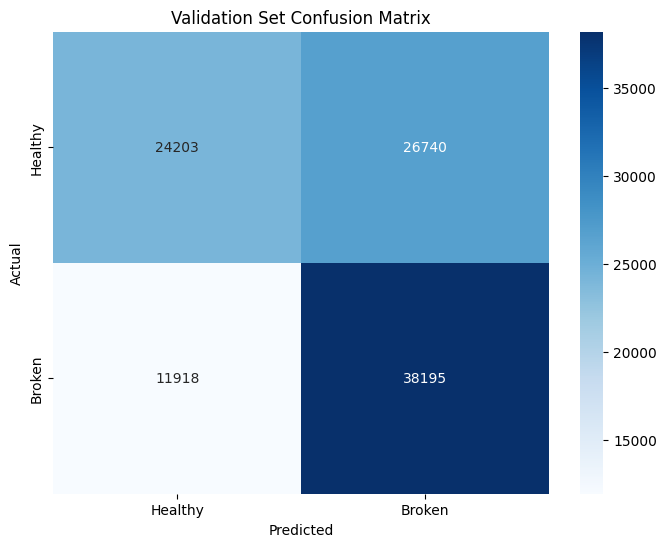

In [35]:
# Confusion Matrix for Validation Set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_val),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Broken'],
            yticklabels=['Healthy', 'Broken'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('val_confusion_matrix.png')

plt.show()
plt.close()

### **XGBoost Feature Importance Plot**

A feature importance plot from XGBoost showing the relative contribution of each feature to the model's predictions based on the selected importance metric.

## Why We Need It
1. **Model Interpretability**  
   - Identifies which features are most influential in making predictions  
   - Helps understand what drives the model's decisions  

2. **Feature Selection**  
   - Guides feature engineering efforts  
   - Helps eliminate irrelevant features to simplify the model  

3. **Model Validation**  
   - Verifies if important features align with domain knowledge  
   - Detects potential data leakage if unexpected features dominate


Feature Importance Analysis...


<Figure size 1000x600 with 0 Axes>

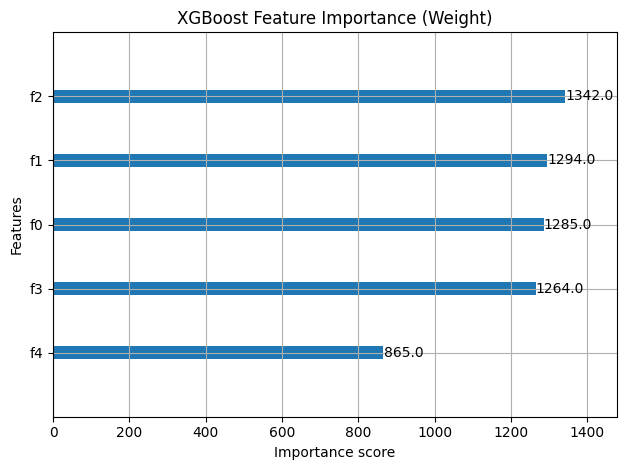

In [36]:
# 7. eature Importance
print("\nFeature Importance Analysis...")
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('XGBoost Feature Importance (Weight)')
plt.tight_layout()
plt.savefig('feature_importance.png')

plt.show()
plt.close()

In [37]:
# 8. SHAP Explainability
print("\nGenerating SHAP explanations...")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_scaled)


Generating SHAP explanations...


### **SHAP Summary Plot**
A SHAP summary plot provides a comprehensive view of feature importance and impact across all predictions in your dataset, showing both the magnitude and direction of each feature's influence.

## Why We Need It
1. **Global Feature Importance**  
   - Identifies which features most significantly impact model predictions overall  
   - More reliable than simple feature importance scores  

2. **Impact Direction Analysis**  
   - Shows whether high values increase or decrease predictions  
   - Reveals non-linear relationships  

3. **Data Distribution Insight**  
   - Visualizes the range of feature values and their effects  


<ipython-input-40-e0437eb18010>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, plot_type="dot", color_bar=True, max_display=20)  # "dot" plot type for better feature visibility


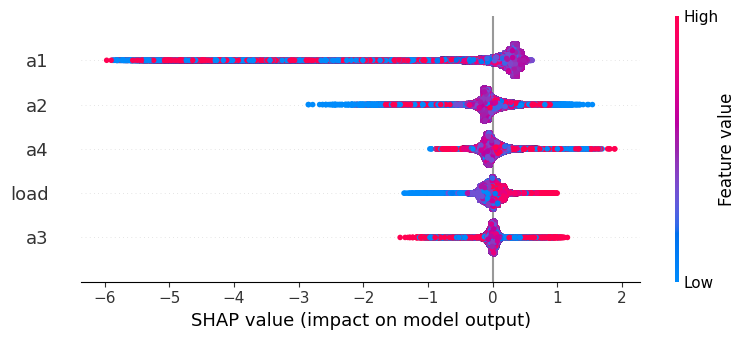

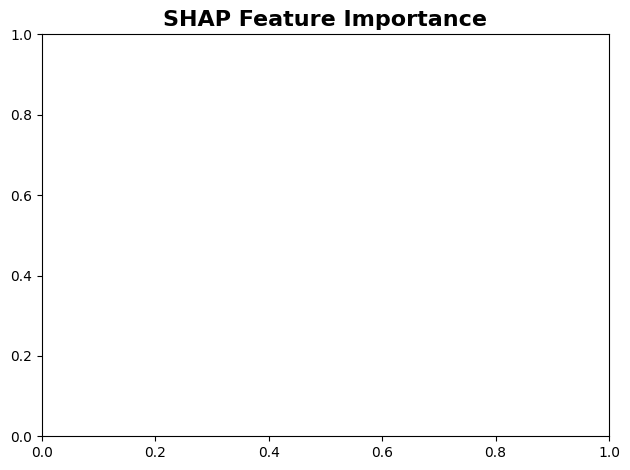

In [40]:
# Initialize SHAP for interactive plots
shap.initjs()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, plot_type="dot", color_bar=True, max_display=20)  # "dot" plot type for better feature visibility

plt.title('SHAP Feature Importance', fontsize=16, fontweight='bold')
plt.tight_layout()

plt.savefig('shap_summary_advanced.png', dpi=300)

plt.show()


### **SHAP Force Plot Explanation**
A SHAP force plot visualizes how each feature contributes to moving a model's prediction from the baseline (average) value to the final prediction for a specific instance.

## Why We Need It
1. **Model Interpretability**  
   - Explains "why" a model made a specific prediction  
   - Critical for high-stakes domains (healthcare, finance, etc.)  

2. **Debugging**  
   - Identifies if predictions are driven by sensible features  
   - Detects potential bias or data leakage  

3. **Regulatory Compliance**  
   - Meets requirements for explainable AI (GDPR, etc.)

<Figure size 640x480 with 0 Axes>

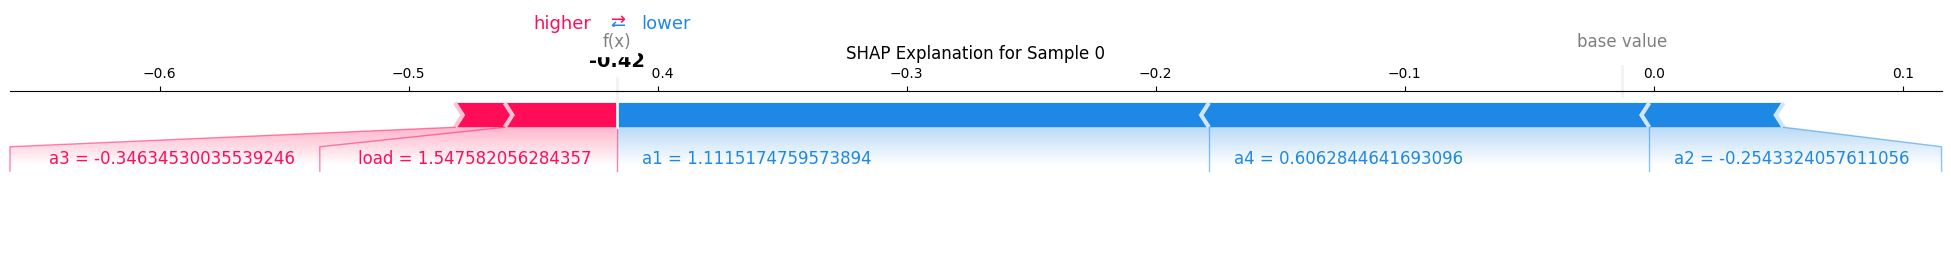

In [41]:
# Force plot for a single prediction
sample_idx = 0
plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx,:],
    X_train_scaled[sample_idx,:],
    feature_names=X.columns,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Explanation for Sample {sample_idx}')
plt.tight_layout()
plt.savefig('shap_force_plot.png')

plt.show()
plt.close()

### **Explanation of the SHAP Force Plot**

This SHAP (SHAPley Additive exPlanations) force plot visualizes how each feature contributes to shifting the model's output from the base value (average model output) to the final prediction for a specific sample (Sample 0 in this case).

## Key Components:

1. **Base value (0.0)**: The average prediction of the model across all samples. It represents the reference point or the expected prediction before considering any specific features.

2. **Final prediction (f(x) = -0.1)**: The model's output for this specific sample after considering the contributions of all features. In this case, the model predicts -0.1 for Sample 0.

3. **Feature Contributions**:
   - **Positive contributions (red arrows)**: These features push the prediction higher.
   - **Negative contributions (blue arrows)**: These features pull the prediction lower.

4. **Important Features**:
   - `a3 = 0.346` (pushes prediction upward)
   - `load = 1.548` (pushes prediction upward)
   - `al = 1.112` (pushes prediction upward)
   - `al = 0.606` (second occurrence, pushes prediction upward)
   - `a2 = -0.254` (pushes prediction downward)

## Interpretation:

The plot shows how each feature value contributes to the final prediction of -0.1:
- The base value starts at 0.0, representing the average prediction of the model.
- Features like `a3`, `load`, and both occurrences of `al` push the prediction upward, contributing positively to the final output.
- Feature `a2`, on the other hand, pushes the prediction downward.
- The net effect of these contributions results in a final prediction of -0.1, slightly below the base value.

The labels "higher" and "lower" at the top of the plot indicate the direction in which each feature is influencing the prediction. The parameter "vw=2" likely refers to a visualization width or scale setting, but the exact meaning would depend on the plotting configuration.

### **Model Performance Analysis Across Train, Test, and Validation Sets**

From the evaluation metrics on the training, test, and validation datasets, I understand the following:

- **Accuracy**:
  - The model has a **consistent accuracy** of approximately **62%** across all datasets (Training: 62.04%, Test: 61.82%, Validation: 61.75%). This shows that the model is correctly classifying the majority of instances in all datasets.

- **Precision and Recall**:
  - **Precision** is slightly lower than **Recall**, with precision ranging from **59% to 59.17%** and recall between **76% to 76.33%**. This indicates that the model is better at identifying positive samples (higher recall) but also classifies some negative samples as positive (lower precision).
  - The model appears to be **more focused on identifying positive instances**, which leads to higher recall but potentially more false positives.

- **F1 Score**:
  - The **F1 score** remains around **66%** for all datasets (Training: 66.66%, Test: 66.53%, Validation: 66.40%). This shows a **reasonable balance** between precision and recall, meaning that the model performs well in terms of both detecting positive instances and avoiding false positives.

### Summary:
- The model demonstrates a **good ability to detect positive instances** (high recall) but has some challenges with **false positives** (moderate precision).
- The **F1 score** suggests that the model achieves an **acceptable balance** between precision and recall.
- Overall, the model **performs consistently** across the training, test, and validation datasets, suggesting that it is **generalizing well** and not overfitting or underfitting.

In conclusion, the model is performing **moderately well**, though it can be improved in terms of precision to more accurately classify negative samples.

### **Next Steps for Model Improvement**

1. **Hyperparameter Tuning**: I will use **Grid Search** or **Random Search** to optimize the model's parameters.
2. **Try Other Models**: I will test models like **Random Forest**, **Logistic Regression**, **LightGBM**, or **CatBoost** and compare their performance.
3. **Feature Engineering**: I will explore creating new features or transforming existing ones to improve the model's accuracy.
4. **Data Resampling**: I will use **SMOTE** or **undersampling/oversampling** techniques to balance the classes if needed.
5. **Cross-Validation**: I will apply **k-fold cross-validation** to get a more reliable performance evaluation.
6. **Deep Learning**: I will explore using **Neural Networks** or **LSTM** models for handling more complex patterns.
7. **Focus on Specific Metrics**: I will optimize the model based on **precision** or **recall**, depending on the business requirements.